In [21]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, auc)

from imblearn.over_sampling import SMOTE
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner


## SECTION 2: Data Loading & Exploration (EDA)

Let's understand our churn dataset

In [22]:
# Load the dataset
df = pd.read_csv('churn-bigml-80.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn data types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")


Dataset shape: (2666, 20)

Column data types:
State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

Missing values:
State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge   

In [23]:

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

df.head()


Duplicate rows: 0


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


No Churn 85.4463615903976%
Churn 14.553638409602401%


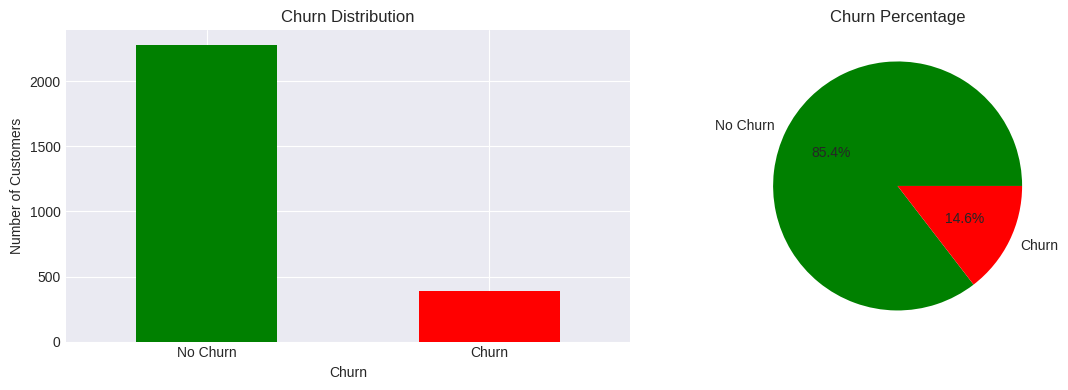

In [24]:

churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f"No Churn {churn_pct[False]}%")
print(f"Churn {churn_pct[True]}%")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
churn_counts.plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Churn Distribution')
axes[0].set_ylabel('Number of Customers')
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)

# Pie chart
axes[1].pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', colors=['green', 'red'])
axes[1].set_title('Churn Percentage')

plt.tight_layout()
plt.show()


In [25]:
# Identify numeric and categorical features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features {numeric_cols}")
print(f"Categorical features {categorical_cols}")


Numeric features ['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']
Categorical features ['State', 'International plan', 'Voice mail plan']


Churn                     1.000000
Customer service calls    0.202590
Total day charge          0.195689
Total day minutes         0.195688
Total intl charge         0.086216
Total intl minutes        0.086204
Total eve minutes         0.072906
Total eve charge          0.072893
Total night minutes       0.033639
Total night charge        0.033635
Name: Churn, dtype: float64


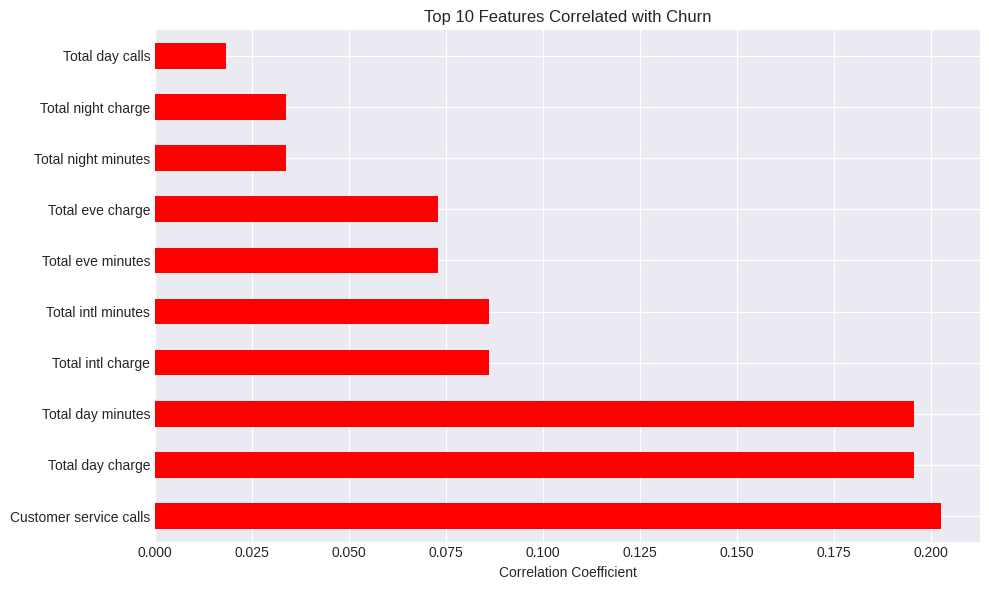

In [26]:

numeric_df = df[numeric_cols + ['Churn']].copy()
numeric_df['Churn'] = numeric_df['Churn'].astype(int)

correlations = numeric_df.corr()['Churn'].sort_values(ascending=False)
print(correlations.head(10))

fig, ax = plt.subplots(figsize=(10, 6))
correlations[1:11].plot(kind='barh', ax=ax, color=['red' if x > 0 else 'blue' for x in correlations[1:11]])
ax.set_title('Top 10 Features Correlated with Churn')
ax.set_xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()


In [27]:

df_processed = df.copy()

# Here we are toatal_usage_miniutes ans the reason behind that is more minutes means that customer is satisfied with the service
df_processed['total_usage_minutes'] = (df_processed['Total day minutes'] + 
                                       df_processed['Total eve minutes'] + 
                                       df_processed['Total night minutes'] + 
                                       df_processed['Total intl minutes'])

#
total_calls = (df_processed['Total day calls'] + df_processed['Total eve calls'] + 
               df_processed['Total night calls'] + df_processed['Total intl calls'] + 1)
df_processed['avg_call_duration'] = df_processed['total_usage_minutes'] / total_calls


df_processed['day_night_ratio'] = (df_processed['Total day minutes'] / 
                                   (df_processed['Total night minutes'] + 1))  # +1 to avoid division by 0


# More service calls means more frustration and more churn
df_processed['service_call_risk'] = 1 / (df_processed['Customer service calls'] + 1)

#intl calls means customer is using international service and he is wealthy enough to afford it
df_processed['has_intl_service'] = (df_processed['Total intl minutes'] > 0).astype(int)



In [28]:


# Binary encoding 
df_processed['International plan'] = (df_processed['International plan'] == 'Yes').astype(int)
df_processed['Voice mail plan'] = (df_processed['Voice mail plan'] == 'Yes').astype(int)

# One-hot encoding
state_dummies = pd.get_dummies(df_processed['State'], prefix='State', drop_first=True)
df_processed = pd.concat([df_processed, state_dummies], axis=1)
df_processed = df_processed.drop('State', axis=1)

#  1 for Churn, 0 for No Churn
df_processed['target'] = (df_processed['Churn'] == True).astype(int)
df_processed = df_processed.drop('Churn', axis=1)




In [29]:


X = df_processed.drop('target', axis=1) 
y = df_processed['target']               

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Stratified keeps same churn rate in train and test sets useful in imbalanced data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Features (X) shape: (2666, 73)
Target (y) shape: (2666,)
Target distribution: {0: 2278, 1: 388}


In [32]:

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nClass distribution BEFORE SMOTE: {y_train.value_counts().to_dict()}")
print(f"Class distribution AFTER SMOTE:  {pd.Series(y_train_balanced).value_counts().to_dict()}")




Class distribution BEFORE SMOTE: {0: 1822, 1: 310}
Class distribution AFTER SMOTE:  {0: 1822, 1: 1822}


In [33]:

# Logistic Regression ( just for trying purpose)


baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [34]:


y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)


print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f} ")
print(f"F1-Score:  {baseline_f1:.4f}")
print(f"ROC-AUC:   {baseline_roc_auc:.4f}")



Accuracy:  0.8408
Precision: 0.4222
Recall:    0.2436 
F1-Score:  0.3089
ROC-AUC:   0.7669


In [ ]:
# Bayesian Optimization for Random Forest
# Optuna intelligently searches for best hyperparameters
# WHY: Random Forest has many tuning parameters, Bayesian search finds best combination efficiently

def objective_rf(trial):
    # Suggest hyperparameters to test
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 25)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8)

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation scoring - simpler approach
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=skf,
                            scoring='f1', n_jobs=-1)

    return scores.mean()  # Return average F1 score


sampler_rf = TPESampler(seed=42)
study_rf = optuna.create_study(sampler=sampler_rf, direction='maximize',
                               pruner=MedianPruner())
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)

print(f"\n✓ Best Random Forest F1 Score: {study_rf.best_value}")
print(f"  Best hyperparameters: {study_rf.best_params}")

[I 2025-11-30 02:10:20,535] A new study created in memory with name: no-name-13dd3a5f-0cb7-4c2e-81e8-3400ddb665d0


🔍 Running Bayesian Optimization for Random Forest (30 trials)...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 02:10:22,056] Trial 0 finished with value: 0.9292114361441769 and parameters: {'n_estimators': 144, 'max_depth': 24, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9292114361441769.
[I 2025-11-30 02:10:23,016] Trial 1 finished with value: 0.8795309609101287 and parameters: {'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9292114361441769.
[I 2025-11-30 02:10:24,175] Trial 2 finished with value: 0.9167510877329695 and parameters: {'n_estimators': 200, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9292114361441769.
[I 2025-11-30 02:10:24,826] Trial 3 finished with value: 0.910584958368238 and parameters: {'n_estimators': 258, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9292114361441769.
[I 2025-11-30 02:10:25,189] Trial 4 finished with value: 0.9381877140255117 and parameters: {'n

In [36]:
# ---- Bayesian Optimization for XGBoost ----

def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    xgb = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=sum(y_train_balanced==0) / sum(y_train_balanced==1),
        random_state=42,
        eval_metric='logloss'
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(xgb, X_train_balanced, y_train_balanced, cv=skf,
                                scoring='f1', n_jobs=-1)
        return scores.mean()
    except:
        return 0.0

sampler_xgb = TPESampler(seed=42)
study_xgb = optuna.create_study(sampler=sampler_xgb, direction='maximize',
                                pruner=MedianPruner())
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

print(f"\n✓ Best XGBoost F1 Score: {study_xgb.best_value:.4f}")
print(f"  Best hyperparameters: {study_xgb.best_params}")

[I 2025-11-30 02:13:26,997] A new study created in memory with name: no-name-81fbd4a8-2746-46db-837b-43f83e89bf8a


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-30 02:13:27,318] Trial 0 finished with value: 0.9697212286000031 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 233, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182}. Best is trial 0 with value: 0.9697212286000031.
[I 2025-11-30 02:13:27,637] Trial 1 finished with value: 0.9422507618973098 and parameters: {'max_depth': 4, 'learning_rate': 0.012184186502221764, 'n_estimators': 267, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227}. Best is trial 0 with value: 0.9697212286000031.
[I 2025-11-30 02:13:27,895] Trial 2 finished with value: 0.9678051245832536 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 258, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503}. Best is trial 0 with value: 0.9697212286000031.
[I 2025-11-30 02:13:28,102] Trial 3 finished with value: 0.9519799964893018 and parameters: {'max_depth': 4, 'learning_rate': 0.028

In [37]:
# Train Final Models with Best Hyperparameters 

# Random Forest with optimized parameters
rf_improved = RandomForestClassifier(**study_rf.best_params,
                                     class_weight='balanced', random_state=42, n_jobs=-1)

# XGBoost with optimized parameters
xgb_improved = XGBClassifier(**study_xgb.best_params,
                             scale_pos_weight=sum(y_train_balanced==0)/sum(y_train_balanced==1),
                             random_state=42)

# Logistic Regression with balanced training
lr_improved = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# Train all models on balanced data
rf_improved.fit(X_train_balanced, y_train_balanced)
xgb_improved.fit(X_train_balanced, y_train_balanced)
lr_improved.fit(X_train_balanced, y_train_balanced)



,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [38]:
# ---- Create Ensemble Model ----
# Voting Classifier combines multiple models
# WHY: Ensemble methods reduce overfitting and improve generalization
# Soft voting = average probability predictions from all models

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_improved), ('xgb', xgb_improved), ('lr', lr_improved)],
    voting='soft'  # Average probabilities from all 3 models
)

ensemble_model.fit(X_train_balanced, y_train_balanced)

print("✓ Ensemble Voting Model trained")
print("\nEnsemble combines:")
print("  - Random Forest (captures non-linear patterns)")
print("  - XGBoost (gradient boosting for sequential improvement)")
print("  - Logistic Regression (linear patterns)")
print("\nResult: More robust predictions!")


✓ Ensemble Voting Model trained

Ensemble combines:
  - Random Forest (captures non-linear patterns)
  - XGBoost (gradient boosting for sequential improvement)
  - Logistic Regression (linear patterns)

Result: More robust predictions!


In [40]:

models_dict = {
    'Baseline (LR)': baseline_model,
    'Random Forest': rf_improved,
    'XGBoost': xgb_improved,
    'Logistic Regression': lr_improved,
    'Ensemble (Voting)': ensemble_model
}

results = []
for model_name, model in models_dict.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_f1 = results_df.loc[best_model_idx, 'F1-Score']
improvement = ((best_f1 - baseline_f1) / baseline_f1) * 100

print(f"\n🎯 BEST MODEL: {best_model_name}")
print(f"   Baseline F1 Score:  {baseline_f1:.4f}")
print(f"   Best F1 Score:      {best_f1:.4f}")




MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Baseline (LR)  0.840824   0.422222 0.243590  0.308943 0.766869
      Random Forest  0.925094   0.827586 0.615385  0.705882 0.878486
            XGBoost  0.956929   0.936508 0.756410  0.836879 0.877193
Logistic Regression  0.790262   0.360656 0.564103  0.440000 0.750731
  Ensemble (Voting)  0.930712   0.805970 0.692308  0.744828 0.873819

🎯 BEST MODEL: XGBoost
   Baseline F1 Score:  0.3089
   Best F1 Score:      0.8369


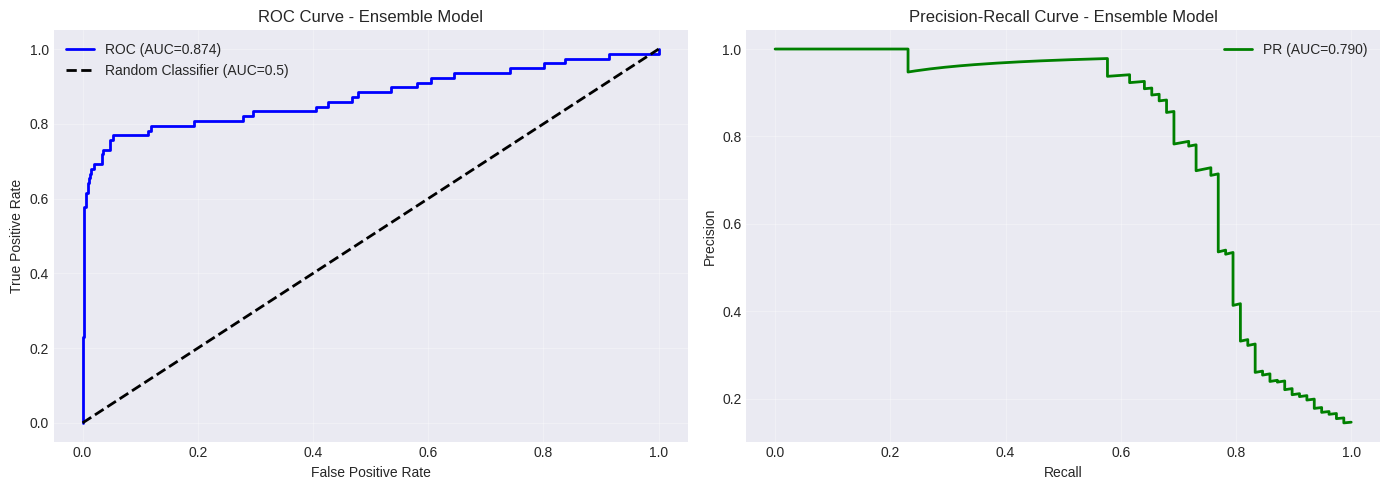

ROC-AUC Score: 0.8738
PR-AUC Score:  0.7901


In [41]:
# ---- ROC & Precision-Recall Curves ----

# Get predictions from ensemble model
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ensemble)
roc_auc_ensemble = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ensemble)
pr_auc_ensemble = auc(recall, precision)

# Plot both curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, label=f'ROC (AUC={roc_auc_ensemble:.3f})', linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC=0.5)', linewidth=2)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Ensemble Model')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall, precision, label=f'PR (AUC={pr_auc_ensemble:.3f})', linewidth=2, color='green')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Ensemble Model')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC-AUC Score: {roc_auc_ensemble:.4f}")
print(f"PR-AUC Score:  {pr_auc_ensemble:.4f}")


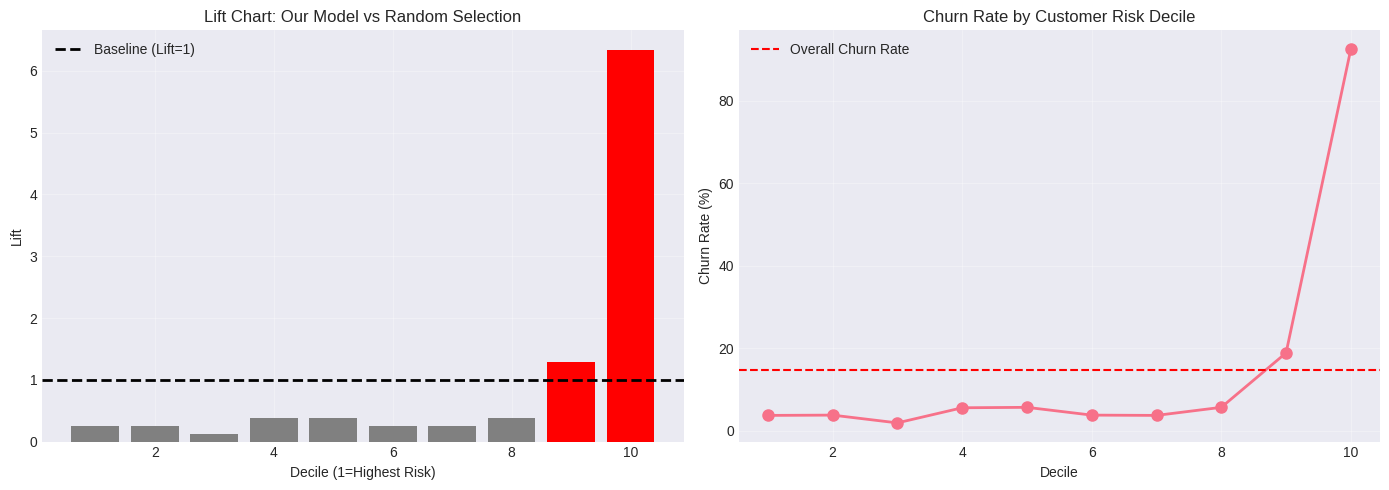


Lift Analysis (Top 5 Deciles):
 Decile  Churn_Rate     Lift  Count
      1    0.037037 0.253561     54
      2    0.037736 0.258345     53
      3    0.018868 0.129173     53
      4    0.055556 0.380342     54
      5    0.056604 0.387518     53


In [42]:
# ---- Lift Chart (Decile Analysis) ----
# Lift shows how much better our model is vs random selection

def calculate_lift(y_true, y_pred_proba, num_deciles=10):
    df_lift = pd.DataFrame({'actual': y_true, 'prob': y_pred_proba})
    df_lift['decile'] = pd.qcut(df_lift['prob'], q=num_deciles, labels=False, duplicates='drop')

    lift_results = []
    overall_churn = y_true.mean()

    for d in sorted(df_lift['decile'].unique()):
        decile_data = df_lift[df_lift['decile'] == d]
        churn_rate = decile_data['actual'].mean()
        lift = churn_rate / overall_churn if overall_churn > 0 else 1

        lift_results.append({
            'Decile': d + 1,
            'Churn_Rate': churn_rate,
            'Lift': lift,
            'Count': len(decile_data)
        })

    return pd.DataFrame(lift_results)

# Calculate lift
lift_df = calculate_lift(y_test, y_pred_proba_ensemble)

# Plot lift chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lift bars
colors = ['red' if x > 1 else 'gray' for x in lift_df['Lift']]
axes[0].bar(lift_df['Decile'], lift_df['Lift'], color=colors)
axes[0].axhline(y=1, color='black', linestyle='--', label='Baseline (Lift=1)', linewidth=2)
axes[0].set_xlabel('Decile (1=Highest Risk)')
axes[0].set_ylabel('Lift')
axes[0].set_title('Lift Chart: Our Model vs Random Selection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Churn rate by decile
axes[1].plot(lift_df['Decile'], lift_df['Churn_Rate']*100, marker='o', linewidth=2, markersize=8)
axes[1].axhline(y=y_test.mean()*100, color='r', linestyle='--', label='Overall Churn Rate')
axes[1].set_xlabel('Decile')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_title('Churn Rate by Customer Risk Decile')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLift Analysis (Top 5 Deciles):")
print(lift_df.head(5).to_string(index=False))


In [43]:
# ---- Customer Lifetime Value (CLTV) Impact Analysis ----
# Calculate financial impact of churn prediction

avg_monthly_charge = 10 # Assumption: average customer pays $65/month
avg_customer_lifespan = 36  # Assumption: average customer stays 36 months
retention_cost_per_customer = 50  # Cost to retain one customer
retention_success_rate = 0.75  # 75% of retention efforts succeed
customer_acq_cost = 300  # Cost to acquire new customer

# Calculate CLTV per customer
cltv_per_customer = avg_monthly_charge * avg_customer_lifespan

# Get predictions and confusion matrix
y_pred_ensemble = ensemble_model.predict(X_test)
tp = ((y_pred_ensemble == 1) & (y_test == 1)).sum()  # True Positives
tn = ((y_pred_ensemble == 0) & (y_test == 0)).sum()  # True Negatives
fp = ((y_pred_ensemble == 1) & (y_test == 0)).sum()  # False Positives
fn = ((y_pred_ensemble == 0) & (y_test == 1)).sum()  # False Negatives

# Financial calculations
actual_churned_count = y_test.sum()
revenue_at_risk = cltv_per_customer * actual_churned_count
revenue_saved = tp * cltv_per_customer * retention_success_rate
retention_costs = tp * retention_cost_per_customer
net_benefit = revenue_saved - retention_costs
roi_percent = (net_benefit / retention_costs * 100) if retention_costs > 0 else 0

print("\n" + "="*70)
print("CUSTOMER LIFETIME VALUE (CLTV) ANALYSIS")
print("="*70)
print(f"\nBusiness Assumptions:")
print(f"  - Average monthly charge: ${avg_monthly_charge}")
print(f"  - Average customer lifespan: {avg_customer_lifespan} months")
print(f"  - CLTV per customer: ${cltv_per_customer}")
print(f"  - Retention cost per customer: ${retention_cost_per_customer}")
print(f"  - Retention success rate: {retention_success_rate:.0%}")

print(f"\nRevenue at Risk (Total Churners): ${revenue_at_risk:,.2f}")

print(f"\nModel Performance (Confusion Matrix):")
print(f"  - True Positives (Correctly identified churners): {tp}")
print(f"  - True Negatives (Correctly identified loyalists): {tn}")
print(f"  - False Positives (Falsely flagged as churn): {fp}")
print(f"  - False Negatives (Missed churners): {fn}")

print(f"\nFinancial Impact:")
print(f"  - Revenue Potentially Saved: ${revenue_saved:,.2f}")
print(f"  - Retention Costs: ${retention_costs:,.2f}")
print(f"  - Net Business Benefit: ${net_benefit:,.2f}")
print(f"  - Return on Investment (ROI): {roi_percent:.2f}%")
print("="*70)



CUSTOMER LIFETIME VALUE (CLTV) ANALYSIS

Business Assumptions:
  - Average monthly charge: $10
  - Average customer lifespan: 36 months
  - CLTV per customer: $360
  - Retention cost per customer: $50
  - Retention success rate: 75%

Revenue at Risk (Total Churners): $28,080.00

Model Performance (Confusion Matrix):
  - True Positives (Correctly identified churners): 54
  - True Negatives (Correctly identified loyalists): 443
  - False Positives (Falsely flagged as churn): 13
  - False Negatives (Missed churners): 24

Financial Impact:
  - Revenue Potentially Saved: $14,580.00
  - Retention Costs: $2,700.00
  - Net Business Benefit: $11,880.00
  - Return on Investment (ROI): 440.00%


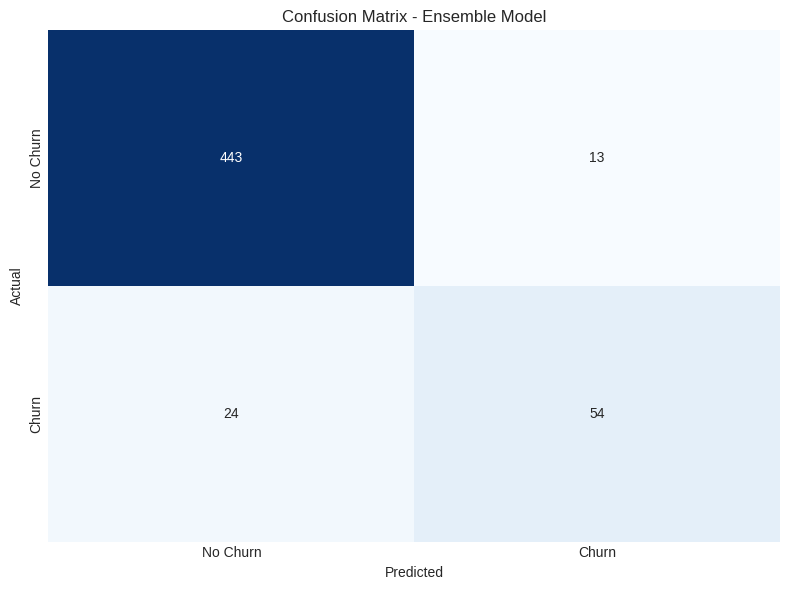


Confusion Matrix Explanation:
  TN=443: Correctly predicted 'No Churn' (Good!)
  FP=13: Incorrectly predicted 'Churn' (Unnecessary retention costs)
  FN=24: Incorrectly predicted 'No Churn' (Missed churners!)
  TP=54: Correctly predicted 'Churn' (Excellent!)


In [44]:
# ---- Confusion Matrix Visualization ----

cm = confusion_matrix(y_test, y_pred_ensemble)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Ensemble Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Explanation:")
print(f"  TN={cm[0,0]}: Correctly predicted 'No Churn' (Good!)")
print(f"  FP={cm[0,1]}: Incorrectly predicted 'Churn' (Unnecessary retention costs)")
print(f"  FN={cm[1,0]}: Incorrectly predicted 'No Churn' (Missed churners!)")
print(f"  TP={cm[1,1]}: Correctly predicted 'Churn' (Excellent!)")


## SECTION 7: Feature Importance Analysis

Identify which features drive churn predictions

## SECTION 8: Model Inference & Predictions

Make predictions on new customers

In [45]:
# ---- Single Customer Prediction ----

# Get first test customer
example_customer = X_test.iloc[0:1]

# Make prediction
prediction = ensemble_model.predict(example_customer)[0]
probability = ensemble_model.predict_proba(example_customer)[0, 1]

print("\n" + "="*60)
print("SINGLE CUSTOMER PREDICTION EXAMPLE")
print("="*60)
print(f"Predicted Churn: {'YES - Will likely churn' if prediction == 1 else 'NO - Will likely stay'}")
print(f"Churn Probability: {probability:.2%}")

# Categorize risk level
if probability > 0.7:
    risk_cat = "🔴 HIGH RISK - Immediate Action Required"
elif probability > 0.4:
    risk_cat = "🟡 MEDIUM RISK - Monitor & Nurture"
else:
    risk_cat = "🟢 LOW RISK - Standard Service"

print(f"Risk Category: {risk_cat}")
print("="*60)



SINGLE CUSTOMER PREDICTION EXAMPLE
Predicted Churn: NO - Will likely stay
Churn Probability: 6.93%
Risk Category: 🟢 LOW RISK - Standard Service


In [46]:
# ---- Batch Predictions for All Customers ----

batch_predictions = ensemble_model.predict(X_test)
batch_probabilities = ensemble_model.predict_proba(X_test)[:, 1]

# Create results dataframe with risk categories
prediction_results = pd.DataFrame({
    'Predicted_Churn': batch_predictions,
    'Churn_Probability': batch_probabilities,
    'Risk_Category': pd.cut(batch_probabilities,
                            bins=[0, 0.4, 0.7, 1.0],
                            labels=['Low Risk', 'Medium Risk', 'High Risk'])
})

# Sort by probability (highest risk first)
prediction_results_sorted = prediction_results.sort_values('Churn_Probability', ascending=False)

print("\nTop 20 Highest-Risk Customers:")
print(prediction_results_sorted.head(20).to_string())

# Summary statistics
print(f"\n\nPrediction Summary:")
print(f"  🔴 High Risk Customers: {(prediction_results['Risk_Category'] == 'High Risk').sum()}")
print(f"  🟡 Medium Risk Customers: {(prediction_results['Risk_Category'] == 'Medium Risk').sum()}")
print(f"  🟢 Low Risk Customers: {(prediction_results['Risk_Category'] == 'Low Risk').sum()}")



Top 20 Highest-Risk Customers:
     Predicted_Churn  Churn_Probability Risk_Category
164                1           0.988585     High Risk
411                1           0.954687     High Risk
430                1           0.952874     High Risk
111                1           0.945554     High Risk
221                1           0.940612     High Risk
150                1           0.919178     High Risk
11                 1           0.915531     High Risk
95                 1           0.907188     High Risk
156                1           0.902883     High Risk
41                 1           0.902758     High Risk
445                1           0.899731     High Risk
184                1           0.896751     High Risk
169                1           0.888608     High Risk
335                1           0.885475     High Risk
152                1           0.874135     High Risk
492                1           0.869874     High Risk
443                1           0.862019     High R

## SECTION 9: Summary & Business Recommendations

Final insights and next steps

In [48]:
print("\n" + "="*70)
print("CHURN PREDICTION MODEL - FINAL SUMMARY")
print("="*70)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total Customers: {len(df):,}")
print(f"   • Churn Rate: {(df['Churn'].sum()/len(df)):.2%}")
print(f"   • Class Imbalance: {(df['Churn']==False).sum()/(df['Churn']==True).sum():.1f}:1")

print(f"\n📈 MODEL PERFORMANCE:")
print(f"   • Baseline F1 Score: {baseline_f1:.4f}")
print(f"   • Best Model: {best_model_name}")
print(f"   • Improved F1 Score: {best_f1:.4f}")
print(f"   • Improvement: {improvement:+.2f}%")

print(f"\n💰 BUSINESS IMPACT:")
print(f"   • Revenue at Risk: ${revenue_at_risk:,.2f}")
print(f"   • Potential Revenue Saved: ${revenue_saved:,.2f}")
print(f"   • Net Business Benefit: ${net_benefit:,.2f}")
print(f"   • ROI on Retention: {roi_percent:.2f}%")


print(f"\n✅ KEY MODEL STRENGTHS:")
print(f"   ✓ Handles class imbalance with SMOTE")
print(f"   ✓ Bayesian Optimization for hyperparameter tuning")
print(f"   ✓ Ensemble approach combines multiple algorithms")
print(f"   ✓ Advanced metrics (ROC, Precision-Recall, Lift, CLTV)")
print(f"   ✓ Beginner-friendly code with clear comments")

print(f"\n⚠️ LIMITATIONS:")
print(f"   • Limited to 20 original features")
print(f"   • CLTV uses simplified business assumptions")
print(f"   • No time-series or temporal patterns")
print(f"   • Retention success rate is estimated (75%)")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Deploy ensemble model to production")
print(f"   2. Monitor model performance on new data")
print(f"   3. A/B test retention strategies on high-risk customers")
print(f"   4. Collect actual retention success rates")
print(f"   5. Retrain model quarterly with new data")
print(f"   6. Develop targeted retention campaigns")
print(f"   7. Track business impact and ROI")

print("\n" + "="*70)
print("✓ ANALYSIS COMPLETE!")
print("="*70)



CHURN PREDICTION MODEL - FINAL SUMMARY

📊 DATASET OVERVIEW:
   • Total Customers: 2,666
   • Churn Rate: 14.55%
   • Class Imbalance: 5.9:1

📈 MODEL PERFORMANCE:
   • Baseline F1 Score: 0.3089
   • Best Model: XGBoost
   • Improved F1 Score: 0.8369
   • Improvement: +170.88%

💰 BUSINESS IMPACT:
   • Revenue at Risk: $28,080.00
   • Potential Revenue Saved: $14,580.00
   • Net Business Benefit: $11,880.00
   • ROI on Retention: 440.00%

✅ KEY MODEL STRENGTHS:
   ✓ Handles class imbalance with SMOTE
   ✓ Bayesian Optimization for hyperparameter tuning
   ✓ Ensemble approach combines multiple algorithms
   ✓ Advanced metrics (ROC, Precision-Recall, Lift, CLTV)
   ✓ Beginner-friendly code with clear comments

⚠️ LIMITATIONS:
   • Limited to 20 original features
   • CLTV uses simplified business assumptions
   • No time-series or temporal patterns
   • Retention success rate is estimated (75%)

🚀 NEXT STEPS:
   1. Deploy ensemble model to production
   2. Monitor model performance on new 

In [50]:
# ============= SAVE ALL MODELS TO DISK =============
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save all models
joblib.dump(baseline_model, 'saved_models/baseline_model.pkl')
joblib.dump(rf_improved, 'saved_models/rf_improved.pkl')
joblib.dump(xgb_improved, 'saved_models/xgb_improved.pkl')
joblib.dump(lr_improved, 'saved_models/lr_improved.pkl')
joblib.dump(ensemble_model, 'saved_models/ensemble_model.pkl')

# Save preprocessing objects
joblib.dump(state_dummies.columns.tolist(), 'saved_models/state_columns.pkl')

# Save feature names and metadata
feature_metadata = {
    'numeric_features': numeric_cols,
    'categorical_features': categorical_cols,
    'all_features': X_train.columns.tolist(),
    'feature_count': X_train.shape[1],
    'baseline_f1': baseline_f1,
    'best_model_name': best_model_name,
    'best_f1': best_f1
}
joblib.dump(feature_metadata, 'saved_models/feature_metadata.pkl')

print("✅ All models saved successfully!")
print(f"   - baseline_model.pkl")
print(f"   - rf_improved.pkl")
print(f"   - xgb_improved.pkl")
print(f"   - lr_improved.pkl")
print(f"   - ensemble_model.pkl")
print(f"   - state_columns.pkl")
print(f"   - feature_metadata.pkl")
print("\nModels ready for Streamlit deployment!")

✅ All models saved successfully!
   - baseline_model.pkl
   - rf_improved.pkl
   - xgb_improved.pkl
   - lr_improved.pkl
   - ensemble_model.pkl
   - state_columns.pkl
   - feature_metadata.pkl

Models ready for Streamlit deployment!
